In [1]:
# Documentation: https://www.prosper.com/Downloads/Services/Documentation/ProsperDataExport_Details.html
from __future__ import division
# import ml
# reload(ml)
# from ml import *
# import rfpimp
# reload(rfpimp)
# from rfpimp import *
import timeit
import scipy
import operator
import numpy as np
import pandas as pd
import cPickle as pickle
from scipy import stats
# import seaborn as sns
from datetime import datetime
from tqdm import tqdm_notebook
from collections import Counter, defaultdict
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.utils import resample
# import statsmodels.api as sm
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('classic')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

'\n    Analysis originaly performed in Python 2 (deprecated)\n    Seaborn, Statsmodel, and * imports broken in Python 3\n'

## Methods

In [2]:
def cov(arr):
    return np.std(arr) / np.mean(arr) 

def fundingTime(arr):
    return (arr.max() - arr.min()).days

def interEventTime(arr):
    return [(t - s).seconds for s, t in zip(sorted(arr), sorted(arr)[1:])]

def avgInterEventTime(arr):
    return np.mean(interEventTime(arr))

def covInterEventTime(arr):
    varr = interEventTime(arr)
    return np.std(varr) / np.mean(varr) 

## Bids

In [5]:
'''
Bid Pre-Processing:
- Filter winning bids
- Remove ongoing listings
'''
bids = pd.read_csv("../Data/bid_notick.txt", sep="|")
# Filter winning bids
bids = bids[bids.Status.isin(["Winning", "Partially Participating"])]
# Remove current listings
bids = bids[bids.ListingStatus.isin(["Expired", "Completed"])]
# Filter relevant columns
bids = bids[["ListingKey", "Bid_Key", "MemberKey", "CreationDate", "Amount", "ListingStatus"]]
# Convert creation date to datetime format
bids["CreationDate"] = pd.to_datetime(bids.CreationDate)
# Variable /YYYY/MM to allow monthly time unit analysis
bids["time_trunc"] = bids.CreationDate.map(lambda x: x.strftime('%Y%m'))
# Rename status colunmn for consistency with other projects
bids = bids.rename(index=str, columns={"ListingStatus": "Status"})
# Exclude these bids in preliminary analysis to correspond to final listing list
# I had to recompute final listings after moving to Mac
with open("../Data/final_listings", 'rb') as f:
    filtered = pickle.load(f)
print "filtered:", len(filtered)
bids = bids[bids['ListingKey'].isin(filtered)] 
# Show sample data
bids.sample(5)

filtered: 143770


,ListingKey,Bid_Key,MemberKey,CreationDate,Amount,Status,time_trunc
5319875,BCA53426857511828AE513F,064635302893711881C05E9,13F833725691978842DD5A1,2008-07-28 18:44:27,50.000,Completed,200807
4452126,06B53419348491976717BCE,FD6635243364756241C062A,C8753417412422199319603,2008-05-01 05:55:44,50.000,Expired,200805
4808846,6C07342196002273640DB35,9C42352562465721155B08C,ED3A3420550121180938089,2008-06-04 20:18:10,50.000,Completed,200806
4959743,1B6F342424204908367ABA1,C28E3527418644092BC323D,8737336441987905197C8B6,2008-06-18 08:23:06,50.000,Completed,200806
290447,2F1F3365941660122D7C4B7,A13D33646265689457727C1,CB6E3365104091797EBB27E,2006-07-27 08:35:30,277.220,Expired,200607


In [6]:
print "Contributors:", bids.MemberKey.nunique(), "Projects:", bids.ListingKey.nunique()
print Counter(bids.Status)

Contributors: 53768 Projects: 143770
Counter({'Completed': 2045450, 'Expired': 843697})


### Bids Aggregation

In [7]:
f = {'ListingKey': ['max'],
     'MemberKey':['nunique'], # Contributor Count
     'Bid_Key': ['nunique'], # Contributions Count
     'CreationDate': ['min', avgInterEventTime, covInterEventTime], # First Contribution Timestamp, AvgInterEventTime, CovInterEventTime
     'Amount': ['min', 'mean', 'max', cov] # Minimum, Mean, Maximum, CoV
}

In [8]:
bids = bids.drop(['time_trunc'], axis=1)
bids = pd.DataFrame(bids.groupby('ListingKey').agg(f).as_matrix())
bids = bids.rename(index=str, columns={0: "NumContributors", 
                                       1: "FirstContributionTimestamp", 
                                       2: "AvgInterEventTime_sec", 
                                       3: "CovInterEventTime", 
                                       4: "MinContributionAmount",
                                       5: "MeanContributionAmount",
                                       6: "MaxContributionAmount", 
                                       7: "CovContributionAmount",
                                       8: "NumContributions",
                                       9: "ProjectID"})
bids.head()

,NumContributors,FirstContributionTimestamp,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID
0,2,2007-03-26 21:32:13,30523.000,0.000,50.000,50.000,50.000,0.000,2,00003383856420083050622
1,1,2007-12-06 21:56:15,NaN,NaN,50.000,50.000,50.000,0.000,1,00003405662222292C12B86
2,2,2008-05-17 12:01:44,597.000,0.000,50.000,75.000,100.000,0.333,2,000034203787284229CBEF1
3,84,2008-06-18 19:53:23,6856.193,1.713,50.000,92.255,600.000,0.958,89,00003423466422120D65CA3
4,1,2007-12-07 19:27:09,NaN,NaN,50.000,50.000,50.000,0.000,1,00013406788490687C1BB75


In [9]:
sum(bids.NumContributions)

2889147

## Listings

In [11]:
columns = ["Lst_Key", "AmountFunded", "StartDate", "EndDate", "Status", "BorrowerRate", "Duration", "ProsperScore", 
           "CreditGrade", "DebtToIncomeRatio", "IsBorrowerHomeowner", "AmountRequested", "MonthlyLoanPayment"]
listings = pd.read_csv('../Data/listing.txt', sep="|")
listings = listings[columns]
listings = listings.rename(index=str, columns={"Lst_Key": "ProjectID",
                                               "AmountFunded": "AmountRaised"})
# Remove current listings
listings = listings[listings['Status'].isin(["Expired", "Completed"])]
listings.head(5)
creditmap = {'AA':8, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'HR':2, 'NC':1}
listings['CreditGrade'] = listings.CreditGrade.fillna(9)
listings = listings.applymap(lambda s: creditmap.get(s) if s in creditmap else s)
listings = listings[listings['CreditGrade']<9] # Drop records with no credit information
listings = listings[listings['StartDate']<'2009'] # Prosper Score Credit Grade Issue: Only take 2005 - 2008 Data
listings.head(5)

,ProjectID,AmountRaised,StartDate,EndDate,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment
0,C0933365069571441D6651D,0.000,2006-02-25 05:51:10,2006-03-04 05:53:21,Expired,0.120,7,nan,3,0.142,NaN,20000.000,664.290
2,9D5E336577848196944F197,0.000,2006-03-15 21:52:45,2006-03-29 21:54:21,Expired,0.080,14,nan,2,0.169,NaN,3000.000,94.010
13,F7C433651616107108B5E83,0.000,2006-04-11 00:52:59,2006-04-21 00:57:26,Expired,0.228,10,nan,4,0.194,NaN,15000.000,572.860
15,AFE53364876098574BEA11A,0.000,2006-04-19 14:20:05,2006-04-26 14:24:40,Expired,0.150,7,nan,1,nan,False,5000.000,167.270
16,ABA53364509248269675D6B,0.000,2006-04-24 18:04:52,2006-04-29 18:09:47,Expired,0.150,5,nan,2,0.026,False,3500.000,121.330


In [12]:
print Counter(listings['Status']), len(listings)
# print Counter(listings[listings['Status'] == 'Expired']['ProsperScore'])

Counter({'Expired': 191247, 'Completed': 29013}) 220260


## Merge Data

In [28]:
data = bids.merge(listings, on="ProjectID", how="left")
data["TimeToFirstContribution (sec)"] = (pd.to_datetime(data.FirstContributionTimestamp) - pd.to_datetime(data.StartDate)).dt.seconds
data["Duration (days)"] = (pd.to_datetime(data.EndDate) - pd.to_datetime(data.StartDate)).dt.days
data = data[data["Duration (days)"] >= 0]
statusmap = {'Completed':1, 'Expired':0}
data = data.applymap(lambda s: statusmap.get(s) if s in statusmap else s)
data.head()

,NumContributors,FirstContributionTimestamp,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,StartDate,EndDate,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days)
0,2,2007-03-26 21:32:13,30523.000,0.000,50.000,50.000,50.000,0.000,2,00003383856420083050622,100.000,2007-03-20 07:20:22,2007-03-27 07:21:53,0,0.120,7.000,nan,6.000,0.340,False,12000.000,392.860,51111.000,7.000
1,1,2007-12-06 21:56:15,nan,nan,50.000,50.000,50.000,0.000,1,00003405662222292C12B86,50.000,2007-11-29 22:13:39,2007-12-06 22:18:09,0,0.215,7.000,nan,3.000,0.300,False,6001.000,227.600,85356.000,7.000
2,2,2008-05-17 12:01:44,597.000,0.000,50.000,75.000,100.000,0.333,2,000034203787284229CBEF1,150.000,2008-05-10 12:32:37,2008-05-17 12:33:12,0,0.309,7.000,nan,4.000,nan,False,3000.000,128.920,84547.000,7.000
3,84,2008-06-18 19:53:23,6856.193,1.713,50.000,92.255,600.000,0.958,89,00003423466422120D65CA3,8210.720,2008-06-18 19:52:15,2008-06-25 19:53:40,0,0.268,7.000,nan,7.000,0.380,True,20000.000,814.360,68.000,7.000
4,1,2007-12-07 19:27:09,nan,nan,50.000,50.000,50.000,0.000,1,00013406788490687C1BB75,50.000,2007-11-27 19:38:18,2007-12-07 19:42:42,0,0.079,10.000,nan,2.000,0.120,True,6000.000,187.630,85731.000,10.000


In [29]:
data[['ProjectID', 'CovInterEventTime', 'CovContributionAmount']].to_csv('momentum_variation_data.csv', index=False)

In [14]:
lender_features = [u'NumContributors', u'AvgInterEventTime_sec', u'CovInterEventTime',
                   u'MinContributionAmount', u'MeanContributionAmount',
                   u'MaxContributionAmount', u'CovContributionAmount', u'NumContributions',
                   u'AmountRaised', u'Status', u'TimeToFirstContribution (sec)', u'Duration (days)']

In [15]:
# with open("../Data/final_listings", 'wb') as f:
#     pickle.dump(list(set(data.ProjectID)), f)

In [16]:
print "Projects:", data.ProjectID.nunique()
print "First Project:", data.StartDate.min(), "\nLast Project:", data.EndDate.max()
print "Duration:", (pd.to_datetime(data.EndDate.max()) - pd.to_datetime(data.StartDate.min()))
print "Mean Duration:", np.mean(data["Duration (days)"])
print "Contributions:", data.NumContributions.sum()
print "Mean Contributors:", np.mean(data.NumContributors)
print "Mean Contribution Amount:", np.mean(data.AmountRaised)
print "Total Raised:", data.AmountRaised.sum()
print "Mean TimeToFirstContribution:", np.mean(data["TimeToFirstContribution (sec)"])
print "Percent Funded:", len(data[data['Status']==1]) / len(data)
    
# with open("../Data/num_contributors_p", 'wb') as f:
#     pickle.dump(list(set(data.NumContributors)), f)
    
# with open("../Data/cov_intereventtime_p", 'wb') as f:
#     pickle.dump(list(set(data.CovInterEventTime)), f)

# with open("../Data/cov_contributionamount_p", 'wb') as f:
#     pickle.dump(list(set(data.CovContributionAmount)), f)

# with open("../Data/timetofirstcontribution_p", 'wb') as f:
#     pickle.dump(list(set(data["TimeToFirstContribution (sec)"])), f)

# with open("../Data/duration_p", 'wb') as f:
#     pickle.dump(list(set(data["Duration (days)"])), f)
    
print "Data pickle success!"

data = data.drop(['FirstContributionTimestamp', 'StartDate', 'EndDate'], axis=1)

Projects: 143549
First Project: 2005-11-09 20:44:28 
Last Project: 2008-10-16 13:44:23
Duration: 1071 days 16:59:55
Mean Duration: 7.029070212958641
Contributions: 2877407
Mean Contributors: 19.04052274832984
Mean Contribution Amount: 1746.2649462552854
Total Raised: 250674586.76999995
Mean TimeToFirstContribution: 39530.57491170262
Percent Funded: 0.202112170757
Data pickle success!


In [17]:
data = data.apply(pd.to_numeric, errors='coerce')
data.describe()

,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days)
count,143549.000,96439.000,96342.000,143549.000,143549.000,143549.000,143549.000,143549.000,1623.000,143549.000,143549.000,143549.000,143549.000,21422.000,143549.000,132064.000,142947.000,143549.000,143549.000,143549.000,143549.000
mean,19.041,19759.482,1.100,68.762,96.257,280.878,0.384,20.045,7401982272935262353340220266572313064202403779325242778666853644362533995489030024920097072759491392529106197663563309500300953741314057633583695812736486983641605988735372270324644536370369726504220992949232029204179044209343583942569043943070583486970383449178289061358635979537444383214436995825664.000,1746.265,0.202,0.210,7.384,4.787,3.787,0.457,0.378,7358.381,272.832,39530.575,7.029
std,40.318,19146.646,0.876,303.900,329.292,717.494,0.513,41.620,inf,3646.545,0.402,0.087,1.845,2.825,1.790,1.192,0.485,6354.280,233.488,36189.402,2.221
min,1.000,0.000,0.000,50.000,50.000,50.000,0.000,1.000,593385153026317184.000,50.000,0.000,0.000,3.000,1.000,1.000,0.000,0.000,1000.000,0.000,0.000,0.000
25%,1.000,5351.237,0.435,50.000,50.000,50.000,0.000,1.000,29273417758761554018304.000,50.030,0.000,0.148,7.000,2.000,2.000,0.140,0.000,3000.000,109.950,355.000,7.000
50%,3.000,13829.800,1.021,50.000,62.500,100.000,0.214,3.000,58703373356609296138240.000,250.000,0.000,0.200,7.000,5.000,3.000,0.240,0.000,5000.000,190.490,33061.000,7.000
75%,16.000,28438.795,1.622,50.000,88.233,280.000,0.667,17.000,88713403234679210901504.000,1500.000,0.000,0.287,10.000,7.000,5.000,0.380,1.000,10000.000,350.770,82388.000,7.000
max,458.000,86389.000,13.947,25000.000,25000.000,25000.000,7.209,460.000,12013417228973928165666829196797503275272204610740996925288234285680926795095578510051225586580428106872620723215835086667488870732358848574144951394934328735331201271156148007938945481988181338830181573048452038830719019050899057351593048697502344855499289192473166515650775414409573840503845423656468480.000,25000.000,1.000,0.497,14.000,10.000,8.000,10.010,1.000,25000.000,1130.900,86399.000,14.000


In [25]:
data.columns

Index([u'NumContributors', u'AvgInterEventTime_sec', u'CovInterEventTime', u'MinContributionAmount', u'MeanContributionAmount', u'MaxContributionAmount', u'CovContributionAmount', u'NumContributions', u'ProjectID', u'AmountRaised', u'Status', u'BorrowerRate', u'Duration', u'ProsperScore', u'CreditGrade', u'DebtToIncomeRatio', u'IsBorrowerHomeowner', u'AmountRequested', u'MonthlyLoanPayment', u'TimeToFirstContribution (sec)', u'Duration (days)'], dtype='object')

In [27]:
data[['ProjectID', 'CovInterEventTime', 'CovContributionAmount']].head()

,ProjectID,CovInterEventTime,CovContributionAmount
0,3383856420083050496.000,0.000,0.000
1,nan,nan,0.000
2,nan,0.000,0.333
3,nan,1.713,0.958
4,nan,nan,0.000


In [19]:
# Time to first contribution in days
print 39530.575/60/60/24
print 36189.402/60/60/24


0.457529803241
0.418858819444


In [20]:
data[["NumContributors", "NumContributions", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)", "Status"]].groupby('Status').describe()


NumContributors                                                  NumContributions                                                  CovInterEventTime                                            CovContributionAmount                                           TimeToFirstContribution (sec)                                                                  Duration (days)                                           
                 count   mean    std   min    25%    50%    75%     max            count   mean    std   min    25%    50%    75%     max             count  mean   std   min   25%   50%   75%    max                 count  mean   std   min   25%   50%   75%   max                         count      mean       std   min      25%       50%       75%       max           count  mean   std   min   25%   50%   75%    max
Status                                                                                                                                                                                                                                                                                                                                                                                                                          
0      114536.000      6.754  16.924 1.000 1.000  2.000  5.000  413.000 114536.000       7.346  17.601 1.000 1.000  2.000  6.000  415.000 67682.000         0.759 0.664 0.000 0.000 0.769 1.152 4.449  114536.000            0.242 0.377 0.000 0.000 0.000 0.354 4.847 114536.000                    46592.437 35646.192 0.000 4667.250 53016.000 84655.000 86399.000 114536.000      7.350 1.833 3.000 7.000 7.000 7.000 10.000
1      29013.000       67.544 62.957 1.000 24.000 47.000 91.000 458.000 29013.000        70.176 64.791 1.000 25.000 49.000 94.000 460.000 28660.000         1.906 0.784 0.000 1.433 1.805 2.250 13.947 29013.000             0.946 0.588 0.000 0.605 0.821 1.099 7.209 29013.000                     11652.126 22128.152 0.000 90.000   290.000   10432.000 86399.000 29013.000       5.762 3.020 0.000 4.000 7.000 7.000 14.000

In [21]:
# Time to first contribution in days (Funded)
print 11652.126/60/60/24
print 22128.152/60/60/24
# Time to first contribution in days (failed)
print 46592.437/60/60/24
print 35646.192/60/60/24

0.134862569444
0.25611287037
0.53926431713
0.412571666667


In [22]:
np.savetxt('projectsgeq4contributions.out', (data.query("NumContributions > 3").ProjectID), delimiter=',', fmt='%s')
np.savetxt('projectsall.out', (data.ProjectID), delimiter=',', fmt='%s')

In [23]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
features_crowd = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)"] 
features_platform = ["BorrowerRate", "ProsperScore", "CreditGrade", "DebtToIncomeRatio", "IsBorrowerHomeowner",
                    "AmountRequested", "MonthlyLoanPayment"]
features_all = features_crowd + features_platform + ["Status"]
cem = scaler.fit_transform(data[features_all].fillna(0))
cem = pd.DataFrame(cem)
cem.columns = features_all
cem.to_csv("../Data/lending_cem_all.csv", index=False)
print Counter(cem['Status'])
cem.head()

Counter({0.0: 114536, 1.0: 29013})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),BorrowerRate,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,Status
0,0.002,0.000,0.000,0.592,0.500,0.241,0.000,0.714,0.034,0.000,0.458,0.347,0.000
1,0.000,0.000,0.000,0.988,0.500,0.432,0.000,0.286,0.030,0.000,0.208,0.201,0.000
2,0.002,0.000,0.046,0.979,0.500,0.622,0.000,0.429,0.000,0.000,0.083,0.114,0.000
3,0.182,0.123,0.133,0.001,0.500,0.539,0.000,0.857,0.038,1.000,0.792,0.720,0.000
4,0.000,0.000,0.000,0.992,0.714,0.158,0.000,0.143,0.012,1.000,0.208,0.166,0.000


## Data Summary

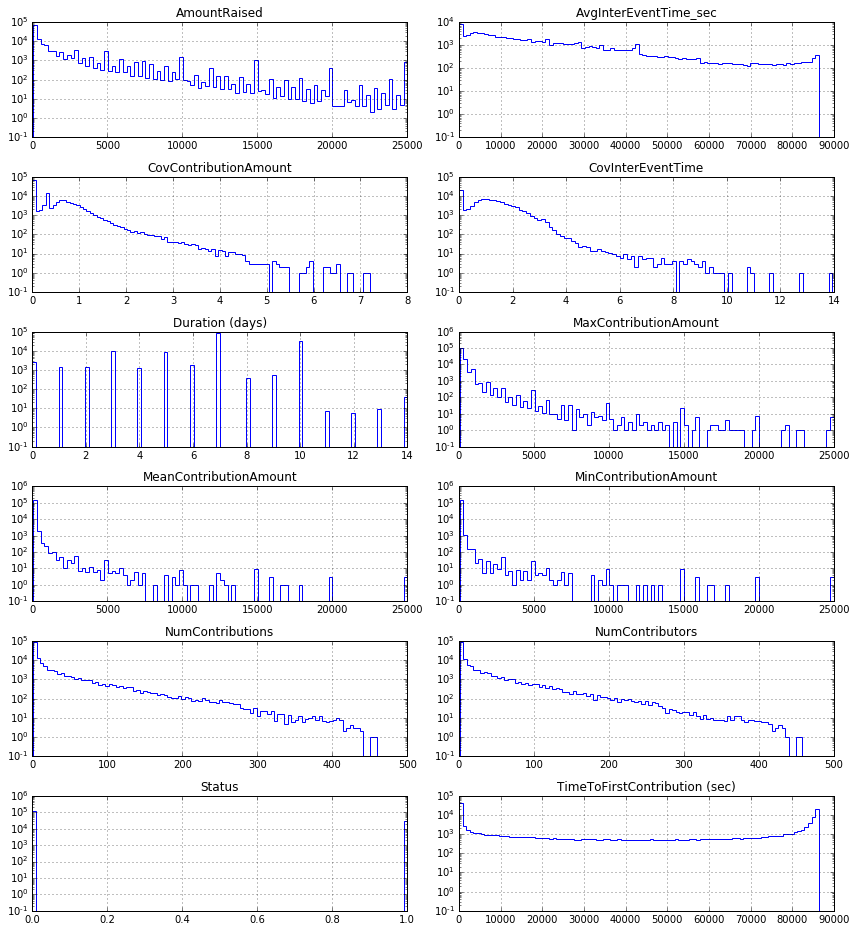

In [24]:
data[lender_features].apply(pd.to_numeric, errors='coerce').hist(figsize=(12,15), 
                                                layout=(7,2), 
                                                histtype='step',
                                                bins=100, 
                                                log=True)
plt.grid()
plt.tight_layout()
plt.show()

## Model Evaluation

In [24]:
data = data.reset_index()
# Separate majority and minority classes
df_majority = data[data.Status==0]
df_minority = data[data.Status==1]
print len(df_majority), len(df_minority)

114536 29013


In [25]:
# Down-sample majority class
df_majority_downsampled = resample(df_majority,
                                  replace = False,
                                  n_samples = len(df_minority),
                                  random_state = 42)


In [26]:
# Combine minority class with down-sampled majority class
downsampled = pd.concat([df_majority_downsampled, df_minority])
print Counter(downsampled.Status)
downsampled.sample(5)

Counter({0: 29013, 1: 29013})


,index,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days)
42292,42368,4,175.333,1.414,50.000,3900.000,15200.000,1.673,4,nan,15600.000,1,0.270,7.000,nan,4.000,0.570,0.000,15600.000,636.870,4.000,0.000
70831,70961,78,3278.354,2.917,50.000,62.511,200.000,0.452,80,nan,5000.000,1,0.140,7.000,8.000,6.000,0.220,0.000,5000.000,170.770,143.000,7.000
30099,30154,3,22529.000,0.279,50.000,50.000,50.000,0.000,3,nan,150.000,0,0.311,7.000,nan,5.000,nan,0.000,3500.000,150.620,41234.000,7.000
139415,139630,47,5290.096,2.005,50.000,149.746,1000.000,1.408,53,nan,7900.000,1,0.285,7.000,1.000,2.000,0.290,0.000,7900.000,328.910,82374.000,6.000
80193,80336,56,7851.982,1.683,50.000,89.699,500.000,0.913,56,nan,5000.000,1,0.102,7.000,8.000,7.000,0.310,0.000,5000.000,161.780,116.000,7.000


### CEM Data Preparation

In [27]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
# CEM variables
cem_features = features_all + ["Status"]

In [28]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
# CEM variables
cem_features = features_all + ["Status"]

In [29]:
cem = scaler.fit_transform(downsampled[cem_features].fillna(-1))
cem = pd.DataFrame(cem)
cem.columns = cem_features
cem.to_csv("../Data/lending_cem.csv", index=False)
print Counter(cem['Status'])
cem.head()

Counter({0.0: 29013, 1.0: 29013})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),BorrowerRate,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,Status
0,0.004,0.072,0.057,0.000,0.714,0.422,0.000,0.000,0.092,0.500,0.083,0.099,0.000
1,0.000,0.000,0.000,0.912,0.500,0.141,0.000,0.286,0.118,0.500,0.167,0.137,0.000
2,0.044,0.146,0.052,0.658,0.500,0.161,0.000,1.000,0.098,1.000,0.083,0.083,0.000
3,0.002,0.067,0.000,0.996,0.500,0.503,0.000,0.286,0.111,0.500,0.125,0.141,0.000
4,0.002,0.067,0.000,0.003,0.714,0.342,0.000,0.143,0.110,0.500,0.000,0.032,0.000


## Evaluation Results

In [30]:
X = downsampled[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = downsampled['Status'].as_matrix()

In [31]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.107993125916 seconds
Completed CART in 0.771661996841 seconds
Completed GNB in 0.0855298042297 seconds
Completed RF in 1.65997505188 seconds
Completed LR in 0.553046941757 seconds
Completed ADB in 6.70323610306 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.838,0.824,0.860,0.842,0.838
1,CART,0.984,0.985,0.982,0.984,0.984
2,GNB,0.897,0.983,0.809,0.887,0.897
3,RF,0.989,0.988,0.990,0.989,0.989
4,LR,0.975,0.976,0.974,0.975,0.975
5,ADB,0.987,0.985,0.988,0.987,0.987


## PIMP


In [32]:
reload(rfpimp)
from rfpimp import *
piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
piRF

,Importance
Feature,
ProsperScore,0.203
NumContributors,0.082
CovContributionAmount,0.056
Duration (days),0.049
CovInterEventTime,0.029
MonthlyLoanPayment,0.029
AmountRequested,0.019
BorrowerRate,0.010
TimeToFirstContribution (sec),0.006


In [33]:
piRF_summary = defaultdict(list)
for i in tqdm_notebook(range(1,10000)):
    reload(rfpimp)
    from rfpimp import *
    piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
    for feature, pi in zip(piRF.Importance.index, piRF.Importance.values):
            piRF_summary[feature].append(pi)

In [34]:
df_piRF = pd.DataFrame()
for feature in features_all:
    df_piRF[feature] = piRF_summary[feature]
df_piRF.to_csv("../Data/prosper_permutation_importance.csv", index=False)
df_piRF.head(5)

,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),BorrowerRate,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment
0,0.097,0.017,0.031,0.002,0.045,0.008,0.210,0.001,0.001,0.000,0.010,0.025
1,0.057,0.020,0.038,0.004,0.048,0.006,0.217,0.003,0.001,0.002,0.015,0.025
2,0.090,0.014,0.045,0.010,0.040,0.013,0.225,0.004,0.000,0.003,0.011,0.017
3,0.069,0.010,0.041,0.006,0.036,0.006,0.233,0.003,-0.000,0.001,0.015,0.021
4,0.071,0.021,0.045,0.004,0.056,0.005,0.216,0.002,0.001,0.002,0.013,0.030


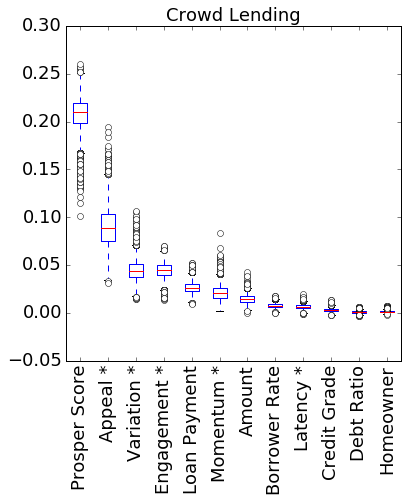

In [60]:
prosper_variables = ["ProsperScore", "NumContributors", "CovContributionAmount", "Duration (days)", "MonthlyLoanPayment", "CovInterEventTime",  "AmountRequested", "BorrowerRate", "TimeToFirstContribution (sec)", "CreditGrade", "DebtToIncomeRatio", "IsBorrowerHomeowner"]
prosper_labels = ["Prosper Score", "Appeal *", "Variation *", "Engagement *", "Loan Payment", "Momentum *", "Amount", "Borrower Rate", "Latency *", "Credit Grade", "Debt Ratio", "Homeowner"]
red_square = dict(markerfacecolor='w', marker='o')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')
ax = df_piRF[prosper_variables].plot.box(figsize=(6,6), rot='vertical', fontsize=18, 
                     flierprops=red_square, 
                     medianprops=medianprops)
ax.set_xticklabels(prosper_labels)
plt.title("Crowd Lending", fontsize=18)
plt.show()

# -------------------------------------- End Main ----------------------------------------

# Supplementary

## Crowd Model

In [36]:
X = data[features_crowd].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status'].as_matrix()

In [37]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.209177970886 seconds
Completed CART in 1.95574498177 seconds
Completed GNB in 0.228826999664 seconds
Completed RF in 5.45113778114 seconds
Completed LR in 0.835122108459 seconds
Completed ADB in 10.7934718132 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.900,0.774,0.710,0.741,0.829
1,CART,0.921,0.807,0.799,0.803,0.875
2,GNB,0.907,0.744,0.824,0.782,0.876
3,RF,0.938,0.855,0.837,0.845,0.900
4,LR,0.913,0.825,0.726,0.772,0.843
5,ADB,0.937,0.846,0.840,0.843,0.901


In [38]:
frank_summary(X, y, features_crowd)

Feature ranking completed in 2.43575286865 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,NumContributors,1,True,0.409,1
1,CovInterEventTime,1,True,0.221,2
2,CovContributionAmount,1,True,0.160,3
3,Duration (days),1,True,0.126,5
4,TimeToFirstContribution (sec),1,True,0.084,4


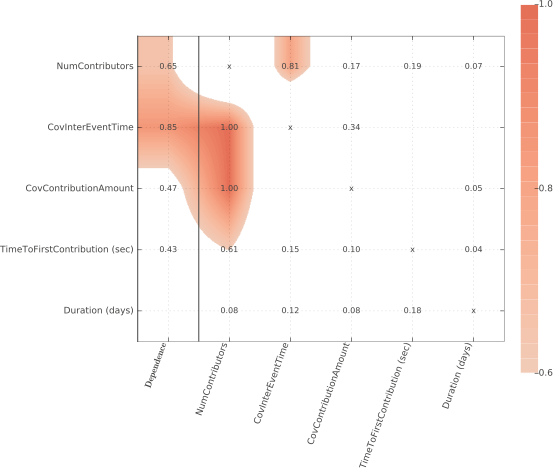

In [39]:
D = feature_dependence_matrix(data[features_crowd].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

### Platform Model

In [40]:
X = data[features_platform].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status']

In [41]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.268351078033 seconds
Completed CART in 1.57641601562 seconds
Completed GNB in 0.259493112564 seconds
Completed RF in 3.51223802567 seconds
Completed LR in 1.13895082474 seconds
Completed ADB in 9.61714696884 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.912,0.802,0.753,0.777,0.853
1,CART,0.936,0.848,0.832,0.840,0.897
2,GNB,0.947,1.000,0.738,0.849,0.869
3,RF,0.950,0.941,0.804,0.867,0.896
4,LR,0.948,0.999,0.741,0.851,0.870
5,ADB,0.952,0.987,0.774,0.868,0.886


In [42]:
frank_summary(X, y, features_platform)

Feature ranking completed in 1.77970194817 seconds


,Feature,RFE Rank,RFE Support,RF Importance,x
0,ProsperScore,1,True,0.648,2
1,MonthlyLoanPayment,1,True,0.087,7
2,BorrowerRate,1,True,0.080,1
3,DebtToIncomeRatio,1,True,0.070,4
4,CreditGrade,1,True,0.055,3
5,AmountRequested,1,True,0.037,6
6,IsBorrowerHomeowner,1,True,0.024,5


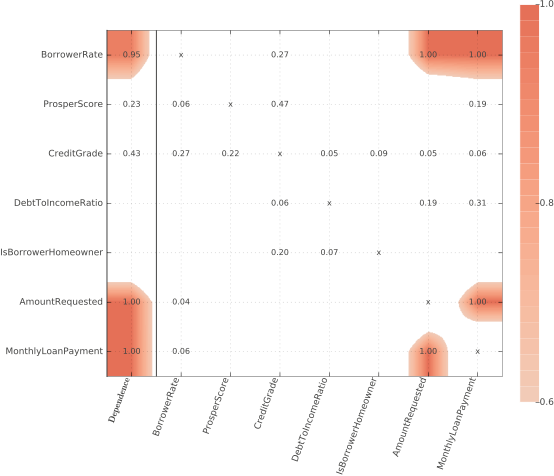

In [43]:
D = feature_dependence_matrix(data[features_platform].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

### All Features

In [44]:
X = data[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = data['Status']

In [45]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.341500043869 seconds
Completed CART in 2.9358921051 seconds
Completed GNB in 0.310189008713 seconds
Completed RF in 4.98718285561 seconds
Completed LR in 1.75810885429 seconds
Completed ADB in 16.5069029331 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.798,0.500,0.863,0.633,0.822
1,CART,0.988,0.970,0.970,0.970,0.981
2,GNB,0.948,0.938,0.797,0.862,0.892
3,RF,0.991,0.984,0.973,0.978,0.984
4,LR,0.978,0.963,0.928,0.946,0.960
5,ADB,0.989,0.978,0.967,0.973,0.981


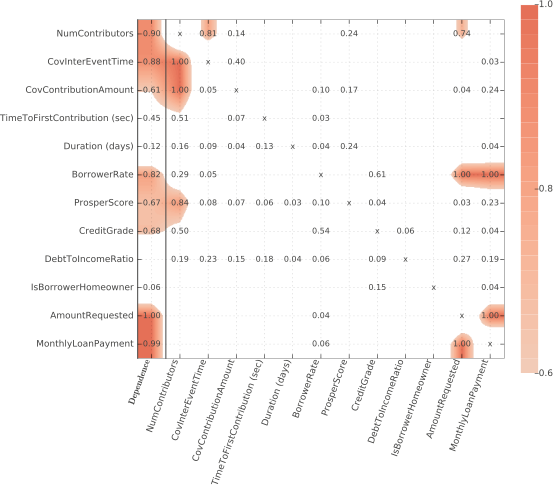

In [46]:
D = feature_dependence_matrix(data[features_all].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## CEM Analysis

In [47]:
cem = pd.read_csv("../Data/cem_results.csv")
cem = cem.drop(['Unnamed: 0'], axis=1)
cem = cem.astype('str')
cem.head()

,BorrowerRate,ProsperScore,CreditGrade,DebtToIncomeRatio,AmountRequested,MonthlyLoanPayment,IsBorrowerHomeowner
0,5,1,6,3,1,7,2
1,8,1,3,3,1,4,2
2,12,1,4,1,1,3,2
3,10,1,7,3,2,13,3
4,3,1,2,2,1,3,3


In [48]:
data["cem"] = cem.apply(lambda x: ''.join(x), axis=1)
data.head()

,index,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days),cem
0,0,2,30523.000,0.000,50.000,50.000,50.000,0.000,2,3383856420083050496.000,100.000,0,0.120,7.000,nan,6.000,0.340,0.000,12000.000,392.860,51111.000,7.000,5163172
1,1,1,nan,nan,50.000,50.000,50.000,0.000,1,nan,50.000,0,0.215,7.000,nan,3.000,0.300,0.000,6001.000,227.600,85356.000,7.000,8133142
2,2,2,597.000,0.000,50.000,75.000,100.000,0.333,2,nan,150.000,0,0.309,7.000,nan,4.000,nan,0.000,3000.000,128.920,84547.000,7.000,12141132
3,3,84,6856.193,1.713,50.000,92.255,600.000,0.958,89,nan,8210.720,0,0.268,7.000,nan,7.000,0.380,1.000,20000.000,814.360,68.000,7.000,101732133
4,4,1,nan,nan,50.000,50.000,50.000,0.000,1,nan,50.000,0,0.079,10.000,nan,2.000,0.120,1.000,6000.000,187.630,85731.000,10.000,3122133


In [49]:
funded_cem = data[data.Status == True]
print len(funded_cem)
funded_cem.head()

29013


,index,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days),cem
8,8,14,8098.571,1.348,50.000,66.737,100.000,0.352,15,nan,1000.000,1,0.350,7.000,6.000,3.000,nan,0.000,1000.000,45.240,10896.000,1.000,13731112
9,9,29,6566.621,2.319,50.000,85.000,300.000,0.686,30,nan,2550.000,1,0.290,10.000,nan,2.000,0.100,0.000,2550.000,106.860,70837.000,3.000,11122122
22,22,53,11178.593,1.571,50.000,63.865,150.000,0.405,55,83422661625108807680.000,3500.000,1,0.105,7.000,9.000,6.000,0.350,0.000,3500.000,113.760,280.000,7.000,41063122
28,28,2,78329.000,0.000,50.000,775.000,1500.000,0.935,2,nan,1500.000,1,0.300,7.000,7.000,2.000,0.040,0.000,1500.000,63.670,8007.000,7.000,11822122
37,37,66,3405.015,3.596,50.000,78.241,250.000,0.619,66,nan,5000.000,1,0.176,7.000,3.000,6.000,nan,0.000,5000.000,179.790,37868.000,7.000,7461132


In [50]:
unfunded_cem = data[data.Status == False]
print len(unfunded_cem)
unfunded_cem.head()

114536


,index,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days),cem
0,0,2,30523.000,0.000,50.000,50.000,50.000,0.000,2,3383856420083050496.000,100.000,0,0.120,7.000,nan,6.000,0.340,0.000,12000.000,392.860,51111.000,7.000,5163172
1,1,1,nan,nan,50.000,50.000,50.000,0.000,1,nan,50.000,0,0.215,7.000,nan,3.000,0.300,0.000,6001.000,227.600,85356.000,7.000,8133142
2,2,2,597.000,0.000,50.000,75.000,100.000,0.333,2,nan,150.000,0,0.309,7.000,nan,4.000,nan,0.000,3000.000,128.920,84547.000,7.000,12141132
3,3,84,6856.193,1.713,50.000,92.255,600.000,0.958,89,nan,8210.720,0,0.268,7.000,nan,7.000,0.380,1.000,20000.000,814.360,68.000,7.000,101732133
4,4,1,nan,nan,50.000,50.000,50.000,0.000,1,nan,50.000,0,0.079,10.000,nan,2.000,0.120,1.000,6000.000,187.630,85731.000,10.000,3122133


In [51]:
unfunded_matched = unfunded_cem[unfunded_cem["cem"].isin(funded_cem["cem"])]
print len(unfunded_matched)
unfunded_matched.head()

54314


,index,NumContributors,AvgInterEventTime_sec,CovInterEventTime,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,CovContributionAmount,NumContributions,ProjectID,AmountRaised,Status,BorrowerRate,Duration,ProsperScore,CreditGrade,DebtToIncomeRatio,IsBorrowerHomeowner,AmountRequested,MonthlyLoanPayment,TimeToFirstContribution (sec),Duration (days),cem
0,0,2,30523.000,0.000,50.000,50.000,50.000,0.000,2,3383856420083050496.000,100.000,0,0.120,7.000,nan,6.000,0.340,0.000,12000.000,392.860,51111.000,7.000,5163172
1,1,1,nan,nan,50.000,50.000,50.000,0.000,1,nan,50.000,0,0.215,7.000,nan,3.000,0.300,0.000,6001.000,227.600,85356.000,7.000,8133142
7,7,2,72857.000,0.000,150.000,175.000,200.000,0.143,2,nan,350.000,0,0.300,7.000,nan,3.000,0.320,0.000,5000.000,212.260,8559.000,7.000,11133142
10,10,1,nan,nan,77.180,77.180,77.180,0.000,1,nan,77.180,0,0.180,7.000,nan,2.000,0.110,1.000,4000.000,144.610,85092.000,7.000,7122133
12,12,39,15341.615,1.211,50.000,93.227,500.000,1.020,40,nan,3729.080,0,0.240,7.000,nan,5.000,0.300,0.000,25000.000,980.820,4744.000,7.000,91532162


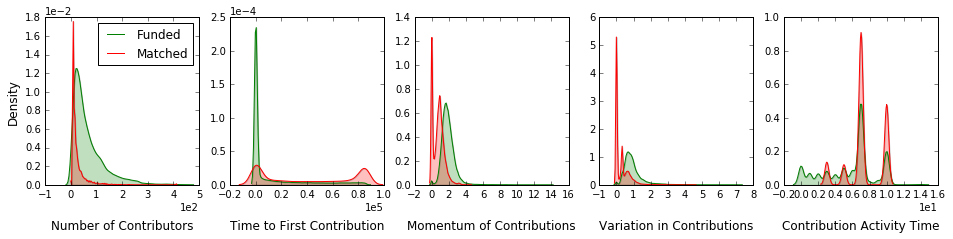

In [52]:
fig = plt.figure(figsize=(16,3))
plt.tick_params(size=12)
b = True
s = 12

plt.subplot(1, 5, 1)
sns.kdeplot(funded_cem["NumContributors"], shade=b, color="g",label="Funded")
sns.kdeplot(unfunded_matched["NumContributors"], shade=b, color="r", label="Matched")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel("Density", size=s)
plt.xlabel("Number of Contributors", size=s, labelpad=20)
plt.legend(loc=1)

plt.subplot(1, 5, 2)
sns.kdeplot(funded_cem["TimeToFirstContribution (sec)"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["TimeToFirstContribution (sec)"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Time to First Contribution", size=s, labelpad=20)

plt.subplot(1, 5, 3)
sns.kdeplot(funded_cem["CovInterEventTime"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["CovInterEventTime"], shade=b, color="r", legend=False)
plt.xlabel("Momentum of Contributions", size=s, labelpad=20)

plt.subplot(1, 5, 4)
sns.kdeplot(funded_cem["CovContributionAmount"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["CovContributionAmount"], shade=b, color="r", legend=False)
plt.xlabel("Variation in Contributions", size=s, labelpad=20)

plt.subplot(1, 5, 5)
sns.kdeplot(funded_cem["Duration (days)"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["Duration (days)"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("Contribution Activity Time", size=s, labelpad=20)

plt.show()

### 2-Sample KS Test

This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the one-sample K-S test, the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

If the K-S statistic is high or the p-value is low, then we can <b>reject the hypothesis that the distributions of the two samples are the same.</b>

In [53]:
print "Appeal:", stats.ks_2samp(funded_cem["NumContributors"], unfunded_cem["NumContributors"])
print "Latency:", stats.ks_2samp(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"])
print "Momentum:", stats.ks_2samp(funded_cem["CovInterEventTime"], unfunded_cem["CovInterEventTime"])
print "Variation:", stats.ks_2samp(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"])
print "Duration:", stats.ks_2samp(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"])

Appeal: Ks_2sampResult(statistic=0.7939866770530337, pvalue=0.0)
Latency: Ks_2sampResult(statistic=0.45782405942112825, pvalue=0.0)
Momentum: Ks_2sampResult(statistic=0.39690966255860516, pvalue=0.0)
Variation: Ks_2sampResult(statistic=0.7043943880607325, pvalue=0.0)
Duration: Ks_2sampResult(statistic=0.3118679817443208, pvalue=0.0)


### Student T-Test

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [54]:
print "Appeal:", stats.ttest_ind(funded_cem["NumContributors"], unfunded_cem["NumContributors"], equal_var=False)
print "Latency:", stats.ttest_ind(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"], equal_var=False)
print "Momentum:", stats.ttest_ind(funded_cem["CovInterEventTime"].dropna(), unfunded_cem["CovInterEventTime"].dropna(), equal_var=False)
print "Variation:", stats.ttest_ind(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"], equal_var=False)
print "Duration:", stats.ttest_ind(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"], equal_var=False)

Appeal: Ttest_indResult(statistic=162.98367906193792, pvalue=0.0)
Latency: Ttest_indResult(statistic=-208.91653386680352, pvalue=0.0)
Momentum: Ttest_indResult(statistic=217.0404489592896, pvalue=0.0)
Variation: Ttest_indResult(statistic=194.09765191120692, pvalue=0.0)
Duration: Ttest_indResult(statistic=-85.68525413937826, pvalue=0.0)


In [55]:
print len(funded_cem["CovInterEventTime"]), len(unfunded_cem["CovInterEventTime"].dropna())

29013 67682


## Feature Correlations

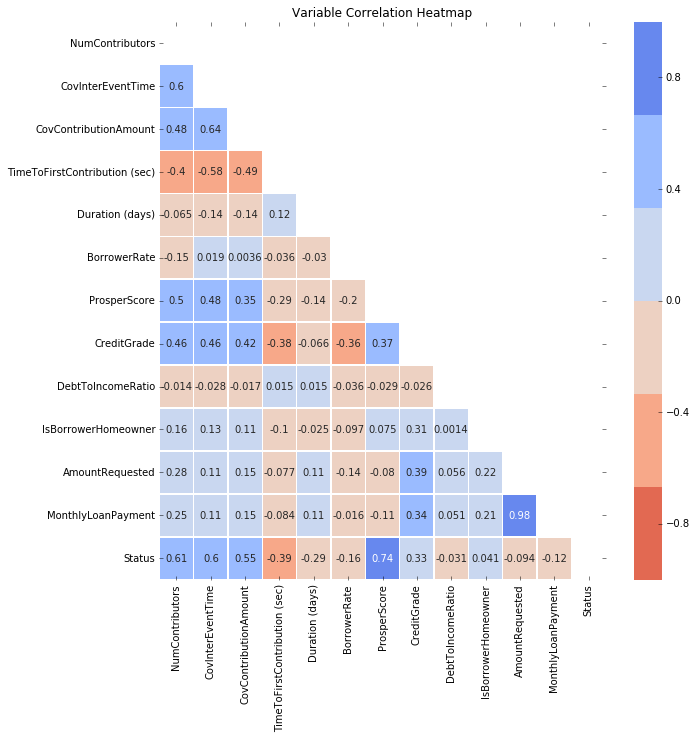

In [61]:
corr = data[features_all+["Status"]].fillna(-1).corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        vmin = -1,
        vmax= 1,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

In [62]:
print stats.pearsonr(data.Status, data['NumContributors'])
print stats.pearsonr(data.Status, data['CovInterEventTime'])
print stats.pearsonr(data.Status, data['CovContributionAmount'])
print stats.pearsonr(data.Status, data['TimeToFirstContribution (sec)'])
print stats.pearsonr(data.Status, data['Duration (days)'])

(0.6054800190679742, 0.0)
(nan, 1.0)
(0.5510556944986392, 0.0)
(-0.3877162636151189, 0.0)
(-0.28723688560964955, 0.0)


In [63]:
momentum_ = data[["Status", "CovInterEventTime"]].dropna()
print stats.pearsonr(momentum_.Status, momentum_.CovInterEventTime)

(0.5986107986385424, 0.0)
